In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cpu


In [73]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [74]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.90 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=32, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=32, shuffle=False)

In [75]:
# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
losses, model, val_losses, val_accuracies = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=150, seed=42, verbose=False, return_val=True, test_loader=iris_test_loader)
print(f"{losses[-5:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.06498469412326813, 0.06484686136245728, 0.06469732969999313, 0.06457400731742383, 0.06443109065294265]


In [76]:
print_training_history(losses, val_losses, val_accuracies, show_last_n=10)

Training Losses (last 10 epochs):
Epoch 141: Train Loss = 0.065737, Val Loss = 0.014048, Val Acc = 1.0000
Epoch 142: Train Loss = 0.065567, Val Loss = 0.013936, Val Acc = 1.0000
Epoch 143: Train Loss = 0.065425, Val Loss = 0.013767, Val Acc = 1.0000
Epoch 144: Train Loss = 0.065287, Val Loss = 0.013593, Val Acc = 1.0000
Epoch 145: Train Loss = 0.065123, Val Loss = 0.013465, Val Acc = 1.0000
Epoch 146: Train Loss = 0.064985, Val Loss = 0.013284, Val Acc = 1.0000
Epoch 147: Train Loss = 0.064847, Val Loss = 0.013157, Val Acc = 1.0000
Epoch 148: Train Loss = 0.064697, Val Loss = 0.013015, Val Acc = 1.0000
Epoch 149: Train Loss = 0.064574, Val Loss = 0.012840, Val Acc = 1.0000
Epoch 150: Train Loss = 0.064431, Val Loss = 0.012719, Val Acc = 1.0000


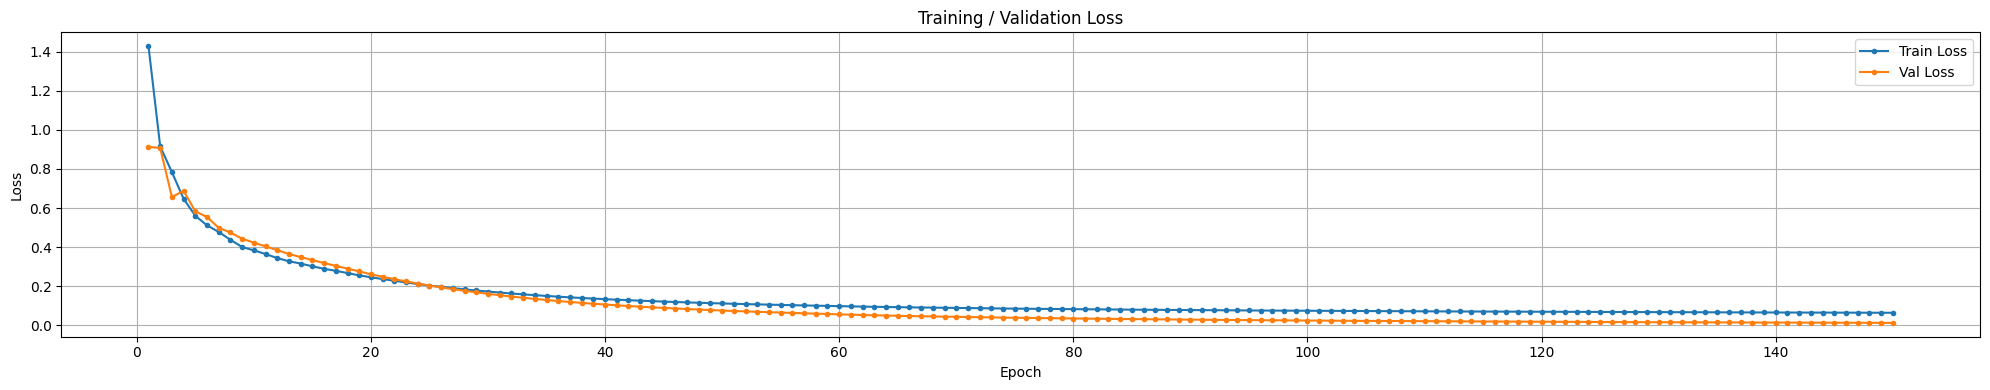

In [77]:
plot_training_history(losses, val_losses, val_accuracies, figsize=(20,4))

In [78]:
base_epochs = 150
extra_epochs = 1
index = 0
k = 5

# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
iris_losses_base, trained_iris_base = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_model2 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_v2 = optim.Adam(iris_model2.parameters(), lr=0.001)
iris_losses_base, trained_iris2 = train_model(iris_model2, iris_train_loader, iris_criterion, iris_optimizer_v2, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris_base, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=k, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=32, shuffle=False)

iris_model3 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_filter = optim.Adam(iris_model3.parameters(), lr=0.001)
iris_losses_base, trained_iris_filter = train_model(iris_model3, iris_train_loader, iris_criterion, iris_optimizer_filter, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_losses_base, trained_iris_filter = train_model(iris_model3, filtered_iris_loader, iris_criterion, iris_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(f"{iris_losses_base[-1:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.06498469412326813, 0.06484686136245728, 0.06469732969999313, 0.06457400731742383, 0.06443109065294265]
All seeds set to: 42
Model weights initialized with seed: 42
[0.06484686136245728, 0.06469732969999313, 0.06457400731742383, 0.06443109065294265, 0.0642970360815525]
All seeds set to: 42
Model weights initialized with seed: 42
[0.06484686136245728, 0.06469732969999313, 0.06457400731742383, 0.06443109065294265, 0.0642970360815525]
[0.057841207622550427]


In [9]:
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris_v2, probabilities_iris_v2, predicted_classes_iris_v2, sample_targets_iris_v2 = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris__filter, probabilities_iris__filter, predicted_classes_iris__filter, sample_targets_iris_filter = predict_and_show(trained_iris_filter, iris_test_loader, dataset_type='iris', indices=index)  # Single index

print(f"{nn.CrossEntropyLoss()(predictions_iris, sample_targets_iris):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter):.8f}")
print(f"Difference: {nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter).item() - nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2).item():.8f}")

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9984      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9985      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.9989      
0.00159196
0.00154864
0.00114471
Difference: -0.00040393


In [ ]:
# Function to calculate CrossEntropy loss for different k and indices (Iris version)
def continue_cross_entropy_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=base_epochs, extra_epochs=extra_epochs):
    """
    For each k and index:
      - find k nearest neighbors for the test sample using activations from the base model
      - create a filtered dataloader excluding those k neighbours
      - train a fresh IrisNet on the full training set for `base_epochs`
      - continue training that fresh model for `extra_epochs` on the filtered set
      - evaluate cross-entropy on the test sample and store the loss

    Returns two dicts:
      - cross_results: {'closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'} mapping k -> list of losses (one per index)
      - dist_results: {'closest_distances', 'last_distances', 'random_distances'} mapping k -> list of distance-lists (k distances per sample)
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    dist_results = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    # Ensure we have the base activations available
    try:
        activations_ref = iris_activations
    except NameError:
        activations_ref = globals().get('iris_activations', None)
        if activations_ref is None:
            raise RuntimeError("iris_activations not found. Run the activation capture cell first.")

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        dist_results['closest_distances'][k] = []
        dist_results['last_distances'][k] = []
        dist_results['random_distances'][k] = []

        for index in list_of_indices:
            # Get activations for the single test sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors across the training activations (return full ranking)
            indices_knn, distances = find_knn(activations_ref, single_activations, k=len(activations_ref), metric='l2')

            # Map idx -> distance for quick lookup
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

            # Build subsets and their distances
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            random_indices = np.random.choice(indices_knn, k, replace=False)
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Create and train a fresh model to the base point
                fresh_model = IrisNet()
                optimizer_tmp = optim.Adam(fresh_model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()

                train_model(fresh_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Continue training for extra_epochs on the filtered dataset
                if extra_epochs > 0:
                    train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                # Predict and calculate CrossEntropy loss for the single test sample
                predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

                # store distances (list of k floats) in the parallel dict
                dist_key = subset_name.replace('_cross_entropy', '_distances')
                dist_results[dist_key][k].append(list(map(float, subset_dists)))

    return cross_results, dist_results

In [67]:
list_of_k = list(range(0, 101, 10))
list_of_k[0] = 1

list_of_indices = list(range(1, 15, 1))
random_indices = random.sample(list_of_indices, k=10)

print(f"List of K: {list_of_k}")
print(f"Random Indices: {random_indices}")

List of K: [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Random Indices: [2, 10, 7, 1, 11, 14, 4, 9, 5, 6]


In [ ]:
cross_results, knn_distances = continue_cross_entropy_for_k_and_indices(trained_iris_base, iris_train_loader, iris_test_loader, list_of_k, random_indices, base_epochs=50, extra_epochs=extra_epochs)

# Save random_indices to a file
with open('continue_data/random_indices_100_l2.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('continue_data/cross_results_100_l2.pkl', 'wb') as f:
    pickle.dump(cross_results, f)

# Save knn_distances to a file
with open('continue_data/knn_distances_100_l2.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9849      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9848      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
11     virginica    virginica    0.9850      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
-----------

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
14     virginica    virginica    0.9991      
Base error for index 14: 0.00086449


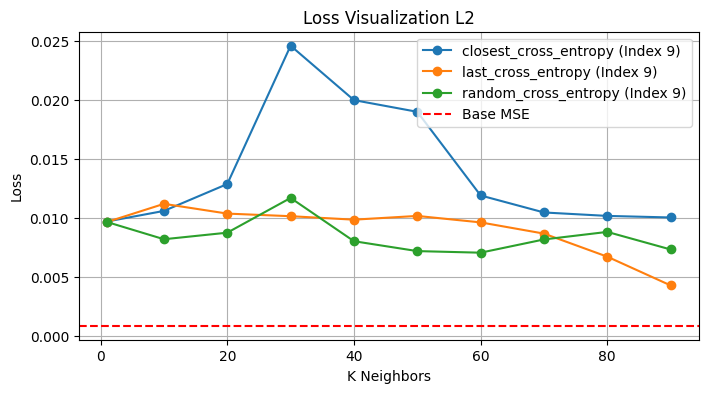

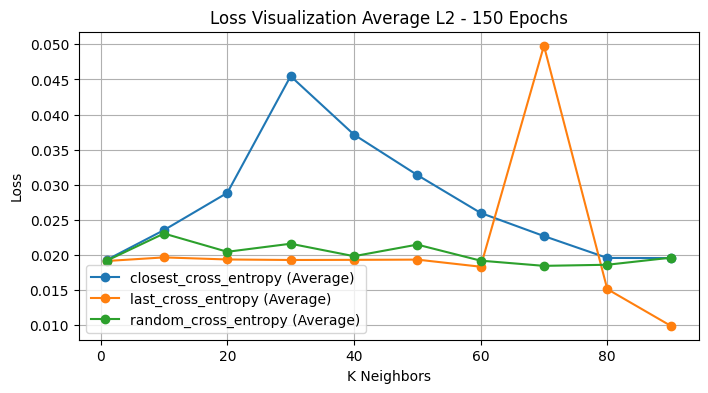

In [61]:
index_base = random_indices[9]
index_pos = random_indices.index(index_base)
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title="Loss Visualization L2", ylabel="Loss", max_knn=101)
visualize_results(cross_results, random_indices, average=True, normalize=False, title="Loss Visualization Average L2 - 150 Epochs")

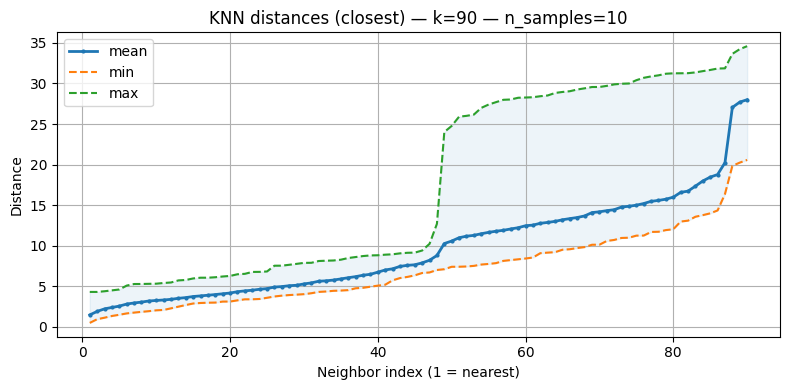

{'k': 90,
 'mean': [1.4623572170734405,
  1.8905544936656953,
  2.2087176203727723,
  2.3790120601654055,
  2.5472853422164916,
  2.7997084856033325,
  2.9344804763793944,
  3.0396029710769654,
  3.1776394605636598,
  3.2421316146850585,
  3.3017629861831663,
  3.381332015991211,
  3.5076616764068604,
  3.595297837257385,
  3.7301435708999633,
  3.8057217836380004,
  3.8879000663757326,
  3.9714340686798097,
  4.0661016464233395,
  4.160117959976196,
  4.323964619636536,
  4.424743485450745,
  4.508240175247193,
  4.622494578361511,
  4.706893897056579,
  4.893976831436158,
  4.954570198059082,
  5.061837673187256,
  5.116329026222229,
  5.283522891998291,
  5.408694887161255,
  5.614112329483032,
  5.665144777297973,
  5.7598731994628904,
  5.898966646194458,
  6.049413251876831,
  6.181934595108032,
  6.354136657714844,
  6.470055770874024,
  6.73104681968689,
  7.002397060394287,
  7.147911596298218,
  7.441330289840698,
  7.575047206878662,
  7.643421220779419,
  7.8761146068573,
 

In [80]:
plot_knn_distance_stats(knn_distances, subset='closest',k=90)
# plot_knn_distance_stats(knn_distances, subset='last')
# plot_knn_distance_stats(knn_distances, subset='random')